# LASSO/RIDGE Logistic Regression Model
- source: R & H

In [395]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_curve, auc, plot_roc_curve, mean_squared_error, accuracy_score, f1_score, confusion_matrix
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def read_csv(filename):
    return pd.read_csv(filename).to_dict('records')

WB_database_codes = read_csv('WB_categories.csv')
data_categories = []
i = 0
for element in WB_database_codes:
    data_categories.append(WB_database_codes[i]['Code'])
    i += 1

# Removal of removed data categories
removed_data_categories = ['SI.POV.MDIM', 'SI.POV.MDIM.XQ', 'SI.POV.MDIM.IT', 'SH.MED.CMHW.P3', 'SH.MED.NUMW.P3', 'SL.WAG.0714.ZS']
for cat in removed_data_categories:
    data_categories.remove(cat)

# Summary code
def summary(model, X, X_train, X_test, y_train, y_test, y_pred, x_sd):
    # print('Lasso alpha:', model.alpha_)
    print('MSE:', mean_squared_error(y_test, y_pred))
    print('R-squared, training', model.score(X_train, y_train))
    print('R-squared, test', model.score(X_test, y_test))
    coef = model.coef_
    print(model.coef_)
    #top_10 = np.argsort(np.abs(coef/x_sd))[::-1][:10]
    #for i in top_10:
    #    print(f'Variable: {X.columns[i]}, Coefficient: {coef[i]}, Significance: {coef[i]/x_sd[i]}')

In [396]:
# Load the dataset - MENA cleaning
df_MENA = pd.read_csv("merged_dfs_MENA_noNA.csv")
df_MENA = df_MENA.drop(columns=["Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0_x", "code", "geo_x", "economy", "Unnamed: 0_y", "country_x", "Time", "geo_y", "country_y", "Unnamed: 0", "iso3"])

df_MENA["time_period"] = ( df_MENA["year"] - 2004 )*12 + df_MENA["month"] - 7 # convert date into an integer
df_MENA = df_MENA[["date", "country_code", "Country", "year", "month", "time_period", "protest", "revolution", "riots", "strike", "unrest", "violence"] + data_categories + ["unrest_index"]]
df_MENA = df_MENA.sort_values(["country_code", "year"])
df_MENA = df_MENA.dropna()
df_MENA = df_MENA.drop(columns=["month", "time_period"])
df_MENA
df_MENA.to_csv(r'merged_dfs_MENA_noNA_v2.csv')

In [397]:
# Load the dataset - world cleaning
df_world = pd.read_csv("merged_dfs_world_noNA.csv")
df_world = df_world.reset_index()
df_world = df_world.drop(columns=["Unnamed: 0.1", "Unnamed: 0_x", "economy", "Unnamed: 0_y", "Time", "Unnamed: 0", "iso3"])

df_world["time_period"] = ( df_world["year"] - 2004 ) # convert date into an integer
df_world = df_world[["date", "country_code", "Country", "year", "time_period", "protest", "revolution", "riots", "strike", "unrest", "violence"] + data_categories + ["unrest_index"]]
df_world = df_world.sort_values(["country_code", "year"])
df_world = df_world.dropna()
df_world.to_csv(r'merged_dfs_world_noNA_v2.csv')

In [398]:
# X = df_world.drop(['date', 'unrest_index', 'country_code', 'Country', 'year', 'time_period'], axis=1)
X = df_MENA.drop(['date', 'unrest_index', 'country_code', 'Country', 'year'], axis=1)

# Calculate sd
x_sd = np.std(X, ddof=1)

print(X.shape)
print(X.duplicated().sum())
print(X.isnull().sum())
X

(913, 55)
0
protest                 0
revolution              0
riots                   0
strike                  0
unrest                  0
violence                0
SN.ITK.MSFI.ZS          0
SI.POV.LMIC.GP          0
EN.ATM.CO2E.PP.GD.KD    0
FR.INR.RINR             0
GC.XPN.INTP.RV.ZS       0
FR.INR.LNDP             0
NY.GDP.DEFL.KD.ZG       0
BX.KLT.DINV.WD.GD.ZS    0
NY.GDP.MKTP.KD          0
NY.GDP.PCAP.KD          0
GC.DOD.TOTL.GD.ZS       0
BN.CAB.XOKA.GD.ZS       0
MS.MIL.XPND.GD.ZS       0
GC.TAX.TOTL.GD.ZS       0
PX.REX.REER             0
PA.NUS.FCRF             0
PA.NUS.PPPC.RF          0
EG.ELC.ACCS.ZS          0
SH.H2O.BASW.ZS          0
SH.STA.BASS.ZS          0
EG.CFT.ACCS.ZS          0
SH.XPD.CHEX.PP.CD       0
SH.MED.BEDS.ZS          0
SP.DYN.LE00.FE.IN       0
SP.DYN.LE00.MA.IN       0
SH.MED.PHYS.ZS          0
SI.POV.GINI             0
SI.DST.10TH.10          0
SI.DST.FRST.10          0
SE.ENR.PRSC.FM.ZS       0
FX.OWN.TOTL.40.ZS       0
SE.ADT.1524.LT.FM.ZS    0


,protest,revolution,riots,strike,unrest,violence,SN.ITK.MSFI.ZS,SI.POV.LMIC.GP,EN.ATM.CO2E.PP.GD.KD,FR.INR.RINR,...,SE.ADT.1524.LT.ZS,SE.TER.CUAT.BA.MA.ZS,SE.TER.CUAT.BA.ZS,SE.TER.CUAT.BA.FE.ZS,EN.URB.LCTY,EN.URB.MCTY.TL.ZS,EN.POP.DNST,EN.POP.SLUM.UR.ZS,SP.URB.TOTL.IN.ZS,SM.POP.TOTL.ZS
0,0.0,5.0,0.0,26.0,1.0,3.0,22.900000,0.8,0.336284,15.453259,...,93.767326,12.479951,14.952974,19.861327,2.592330e+06,6.555699,16.602626,24.981210,70.848000,0.611072
1,0.5,4.0,0.0,20.0,0.0,5.0,22.783333,0.8,0.335179,14.694881,...,93.767326,12.439813,14.906779,19.800775,2.595106e+06,6.551797,16.630482,24.655760,70.898917,0.611072
2,0.0,4.0,0.0,20.0,0.0,4.0,22.666667,0.8,0.334073,13.936503,...,93.767326,12.399674,14.860583,19.740222,2.597881e+06,6.547895,16.658339,24.330310,70.949833,0.611072
3,0.0,3.0,0.0,15.0,0.0,3.0,22.550000,0.8,0.332968,13.178125,...,93.767326,12.359536,14.814388,19.679669,2.600657e+06,6.543994,16.686196,24.004860,71.000750,0.611072
4,0.5,4.0,0.0,13.0,0.0,5.0,22.433333,0.8,0.331863,12.419747,...,93.767326,12.319397,14.768192,19.619116,2.603433e+06,6.540092,16.714053,23.679410,71.051667,0.611072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,0.0,13.0,0.0,7.0,0.0,11.0,21.575000,0.4,0.228429,-5.197892,...,96.209099,25.402760,25.975220,26.886909,2.281640e+06,19.168972,76.613295,8.268295,68.869250,0.503850
909,1.0,11.0,0.0,5.0,0.0,8.0,21.750000,0.4,0.227894,-5.197892,...,96.209099,25.402760,25.975220,26.886909,2.284685e+06,19.178290,76.678519,8.226610,68.894500,0.503850
910,0.5,11.0,0.0,6.0,0.0,5.0,21.925000,0.4,0.227359,-5.197892,...,96.209099,25.402760,25.975220,26.886909,2.287731e+06,19.187608,76.743742,8.184925,68.919750,0.503850
911,0.0,10.0,1.0,7.0,0.0,5.0,22.100000,0.4,0.226824,-5.197892,...,96.209099,25.402760,25.975220,26.886909,2.290777e+06,19.196926,76.808966,8.143240,68.945000,0.503850


/Users/matthewchiu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.09760097223813, tolerance: 0.05048253313696631
  model = cd_fast.enet_coordinate_descent_gram(
/Users/matthewchiu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.8109965880408, tolerance: 0.05048253313696631
  model = cd_fast.enet_coordinate_descent_gram(
/Users/matthewchiu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.5936343599891, tolerance: 0.05048253313696631
  model = cd_fast.enet_coordinate_descent_gram(
/Users/matthewchiu/opt/anaconda3/

Lasso alpha: 0.0001
MSE: 0.4847749839632642
R-squared, training 0.6109485029474924
R-squared, test 0.48531029322678254
[-9.22634720e-04  1.99860474e-02  6.40152105e-03 -1.69409695e-03
  1.79834317e-03  7.38074568e-04 -1.38882023e-02  4.91008186e-02
 -4.89659487e+00  2.05306037e-02 -8.85401744e-02  1.64792668e-01
  3.08604092e-02 -3.02069002e-02 -7.07630243e-12 -8.97252653e-06
 -1.28060772e-02 -1.74270794e-02 -1.85550784e-02 -6.73114379e-02
 -1.28040954e-02 -1.66589255e-03  1.96134836e+00  2.51040954e-02
  4.06096112e-02  1.52720923e-02 -1.49909364e-01  2.36681809e-03
  6.33852642e-01 -5.63868170e-01  1.46311995e-02 -2.68429819e-01
  1.67518104e-01 -1.08284105e-01 -5.96004955e-01  9.03658137e+00
 -1.43316873e-03  0.00000000e+00 -4.88030843e-02 -1.19467515e-02
  4.01495934e-02 -3.51599249e-02 -1.60692693e-07 -1.37579751e-08
  4.77290588e-02 -3.42796856e-03  1.12646590e-01 -6.48187461e-03
 -2.30580875e-01  3.69874273e-07  7.06017779e-03  6.54610455e-03
 -7.35352757e-02  1.97056517e-02 -4.

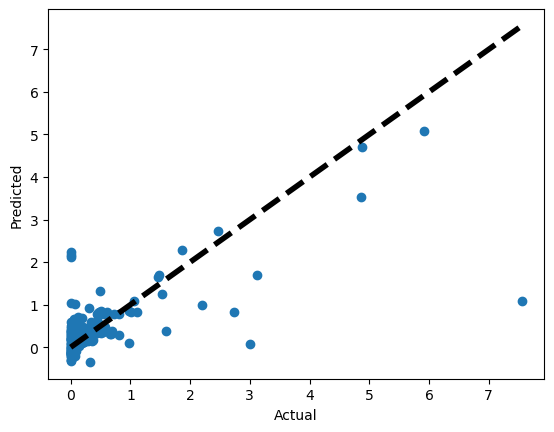

In [399]:
# Load your data into X and y
# Split your data into training and testing sets
y = df_MENA['unrest_index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Lasso model with alpha values
alphas = np.logspace(-4,4,20)
lasso_cv = LassoCV(alphas=alphas, cv=10)
lasso = Lasso(alpha=20)

# Fit the Lasso model on the training data
lasso_cv.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lasso_cv.predict(X_test)

# Calculate the mean squared error of the predictions
print('Lasso alpha:', lasso_cv.alpha_)
summary(lasso_cv, X, X_train, X_test, y_train, y_test, y_pred, x_sd)
top_10 = np.argsort(np.abs(lasso_cv.coef_/x_sd))[::-1][:10]
for i in top_10:
    print(f'Variable: {X.columns[i]}, Coefficient: {lasso_cv.coef_[i]}, Significance: {lasso_cv.coef_[i]/x_sd[i]}')


plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

0.41711229946524064
Accuracy 0.6557377049180327
F1 <function f1_score at 0x168f20c10>
NY.GDP.MKTP.KD 3.864679566686176e-12
PA.NUS.FCRF 1.1798623050804093e-13
riots 6.746318951936194e-14
NY.GDP.DEFL.KD.ZG -3.840906084409008e-15
EN.ATM.CO2E.PP.GD.KD -8.563298323232567e-15
PA.NUS.PPPC.RF -1.3059725171214643e-14
SE.ADT.1524.LT.FM.ZS -2.6470039020976628e-14
BN.CAB.XOKA.GD.ZS -2.937317269301614e-14
SE.ENR.PRSC.FM.ZS -3.1416572526679814e-14
SH.MED.PHYS.ZS -4.828930586956087e-14


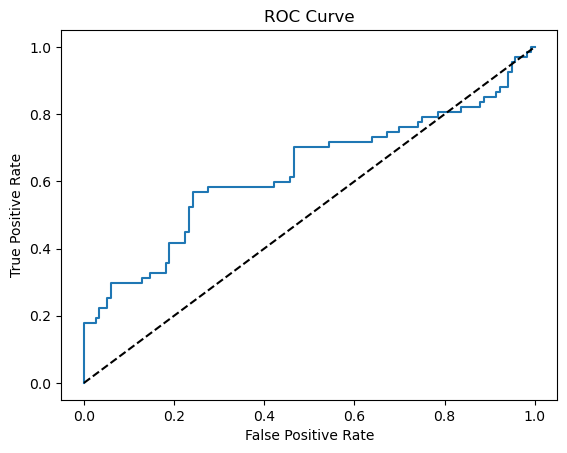

MSE: 0.3442622950819672
R-squared, training 0.6082191780821918
R-squared, test 0.6557377049180327
[[-1.29409138e-13 -1.52174477e-13  6.74631895e-14 -4.21949194e-13
  -6.77219470e-14 -4.16501555e-13 -7.10240268e-13 -6.07699635e-14
  -8.56329832e-15 -1.01211079e-13 -8.11046170e-13 -7.84239766e-14
  -3.84090608e-15 -1.35366368e-13  3.86467957e-12 -3.97872590e-10
  -1.99083441e-12 -2.93731727e-14 -1.19752574e-13 -6.08255101e-13
  -3.02673447e-12  1.17986231e-13 -1.30597252e-14 -2.80266786e-12
  -2.62059979e-12 -2.62411443e-12 -2.93635394e-12 -2.61615275e-11
  -6.39425206e-14 -2.34297318e-12 -2.24170331e-12 -4.82893059e-14
  -1.08611177e-12 -8.70197799e-13 -8.76928736e-14 -3.14165725e-14
  -1.34014311e-12 -2.64700390e-14 -6.94969159e-13 -7.55907635e-13
  -3.36031049e-13 -3.98020272e-13 -1.02429901e-07 -1.15028561e-09
  -2.36530800e-12 -2.51869970e-12 -3.12468233e-13 -3.76986406e-13
  -5.28137813e-13 -2.87706788e-08 -7.80466132e-13 -4.69852348e-12
  -3.17892334e-13 -2.39898892e-12 -8.7018761

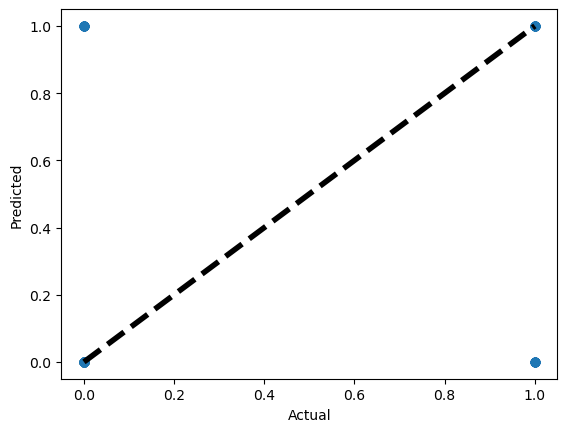

In [400]:
# Define a threshold value to convert to binary and Create a binary variable based on the threshold
threshold_MENA = 0.26
threshold_world = 0.13
df_MENA['unrest_index_binary'] = np.where(df_MENA['unrest_index'] >= threshold_MENA, 1, 0)
df_world['unrest_index_binary'] = np.where(df_world['unrest_index'] >= threshold_world, 1, 0)
y = df_MENA['unrest_index_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Lasso model with alpha=0.1
lasso_logistic = LogisticRegression(penalty='l2')

# Fit the Lasso model on the training data
lasso_logistic.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lasso_logistic.predict(X_test)
y_prob = lasso_logistic.predict_proba(X_test)[:,1]

# calculate fpr, tpr and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+tn)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
print(f1)
print('Accuracy', accuracy)
print('F1', f1_score)

coef_abs = lasso_logistic.coef_[0]
coef_dict = dict(zip(X.columns, coef_abs))
sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda item: item[1], reverse=True))

# print the top 10 features with the highest importance scores
for feature, score in list(sorted_coef_dict.items())[:10]:
    print(feature, score)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # random curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

summary(lasso_logistic, X, X_train, X_test, y_train, y_test, y_pred, x_sd)
print(lasso_logistic.coef_)

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

MSE: 0.11807026846824373


/Users/matthewchiu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.45266e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


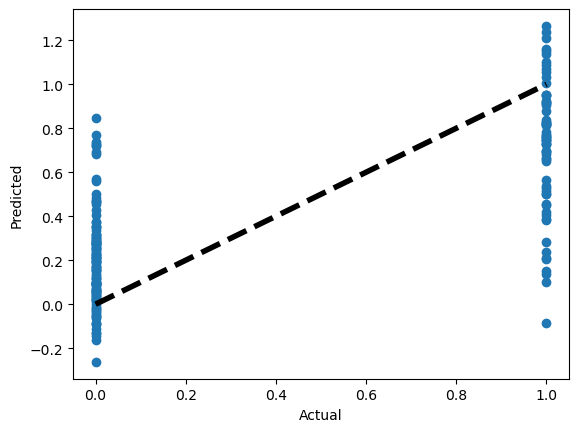

In [401]:
# Initialize the Ridge model
ridge = Ridge(alpha=0.1)

# Load your data into X and y
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Ridge model on the training data
ridge.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ridge.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

# Print the mean squared error
print('MSE:', mse)
# print('R-squared', r2)

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [402]:
# Set the number of years to predict and train on
num_months = len(df_MENA['time_period'].unique()) # = 181
train_months = 36

# Split the data into training and testing sets based on years
tscv = TimeSeriesSplit(n_splits=num_months - train_months)


KeyError: 'time_period'

In [ ]:

# Iterate through each year and fit the model
for train_index, test_index in tscv.split(X):
    # Set the training and testing data for the current year
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Skip the first 36 months (time_period 0 to 35)
    if X_test['time_period'].min() < 36:
        continue

    # Select only the past three years for training data
    X_train = X_train[X_train['time_period'] >= X_test['time_period'].min() - train_months]

    # Fit the Lasso model on the training data
    lasso.fit(X_train, y_train)

    # Predict the probability of the dependent variable for the current year
    y_pred = lasso.predict(X_test)

    # Print the mean squared error for the current year
    print('Month:', X_test['time_period'].min(), 'MSE:', ((y_pred - y_test) ** 2).mean())
